# Required Packages

In [1]:
import mysql.connector as mysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from anytree import Node, RenderTree, PreOrderIter
from anytree.exporter import DotExporter
from scipy.stats import norm
import copy
import sys
from anytree.exporter import JsonExporter
from bayes_tree.bayes_tree import bayes_tree
import config as cfg
from itertools import chain
import MySQLdb.cursors
import MySQLdb
import pickle

# Get Replay Master List

## Database Connections

In [2]:
database_list = ['sc_pvp','sc_pvt','tvt']  # 'sc_pvz' 'tvz','zvz'
connection_list = []
cursor_list = []
for database in database_list:
    db = MySQLdb.connect(
    host = cfg.credentials['host'],
    user = cfg.credentials['user'],
    passwd = cfg.credentials['passwd'],
    database = database,
    cursorclass = MySQLdb.cursors.SSCursor)
    connection_list.append(db)
    cursor_list.append(db.cursor())

## Replays, filtered by time

In [3]:
def get_replays(cursor):
    query = """
        SELECT ReplayID, Duration FROM replay
        """
    cursor.execute(query)
    return cursor.fetchall()

In [4]:
replay_list = []
for index,cursor in enumerate(cursor_list):
    replay_list.append(get_replays(cursor))

2804


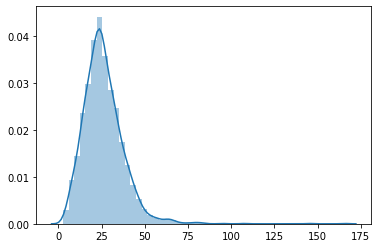

In [5]:
replay_times = [x[1]/60/24 for replays in replay_list for x in replays]
print(len(replay_times))
sns.distplot(replay_times)

In [9]:
TIME = cfg.TIME
LIVE_REPLAY_LIST = []
for replays in replay_list:
    LIVE_REPLAY_LIST.append(list(filter(lambda x: x[1]>=TIME,replays)))
print(len(list(chain.from_iterable(LIVE_REPLAY_LIST))))

2663


## Get Respective PlayerReplayIDs

In [10]:
def get_player_replays(replayids,cursor):
    replayids_string = ",".join(str(x) for x in replayids)
    query = """
        SELECT PlayerReplayID, RaceID FROM playerreplay
        WHERE RaceID != 5 AND ReplayID in ({});
        """.format(replayids_string)
    cursor.execute(query)
    return cursor.fetchall()

In [11]:
LIVE_PLAYER_REPLAY_LIST = []
for index,replays in enumerate(LIVE_REPLAY_LIST):
    cursor = cursor_list[index]
    LIVE_PLAYER_REPLAY_LIST.append(get_player_replays([replay[0] for replay in replays],cursor))

In [12]:
len(list(chain.from_iterable(LIVE_PLAYER_REPLAY_LIST)))

5326

# Get Unit Counts

## SQL Requests

In [13]:
def get_units(playerreplayIDs,time,cursor):
    
    playerreplayIDs_string = ",".join(str(x) for x in playerreplayIDs)
    query = """
        SELECT playerreplay.PlayerReplayID, UnitTypeID, ChangeVal
        FROM (attributechange LEFT JOIN unit ON unit.UnitID = attributechange.UnitID) 
        LEFT JOIN playerreplay ON playerreplay.PlayerReplayID = unit.PlayerReplayID
        WHERE AttributeTypeID = 28 AND unit.PlayerReplayID in ({}) AND ChangeTime <= {};
        """.format(playerreplayIDs_string,time)
    print(query)

    cursor.execute(query)
    results = cursor.fetchall()
    
    ids = set(map(lambda x:x[0], results))
    print('got here 2')
    results_by_ids = [[y[1:3] for y in results if y[0]==x] for x in ids]
    
    return results_by_ids,ids

def process_units(results_by_ids):
    
    units_by_replay = []
    
    for result in results_by_ids:

        unit_dict = {n: 0 for n in cfg.cluster_unit_list}
        for unit in result:
            key = unit[0]
            if key in cfg.unit_converts.keys():
                key = cfg.unit_converts[key]
            if key in unit_dict.keys():
                val = unit[1] * 2 - 1
                unit_dict[key] += val
                
        units_by_replay.append(unit_dict)
            
    return units_by_replay

In [14]:
raw_units_list = []
id_list = []
for index,player_replays in enumerate(LIVE_PLAYER_REPLAY_LIST):
    cursor = cursor_list[index]
    raw_units , ids = get_units([replay[0] for replay in player_replays],TIME,cursor)
    raw_units_list.append(raw_units)
    id_list.append(ids)


        SELECT playerreplay.PlayerReplayID, UnitTypeID, ChangeVal
        FROM (attributechange LEFT JOIN unit ON unit.UnitID = attributechange.UnitID) 
        LEFT JOIN playerreplay ON playerreplay.PlayerReplayID = unit.PlayerReplayID
        WHERE AttributeTypeID = 28 AND unit.PlayerReplayID in (237,238,239,240,242,243,244,247,248,249,250,251,252,253,254,257,258,259,262,263,264,265,266,267,272,273,274,275,276,277,282,283,284,285,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,325,326,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,377,378,381,382,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,409,410,413,414,415,416,421,422,423,424,427,428,429,430,431,432,435,436,439,440,443,444,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462

got here 2

        SELECT playerreplay.PlayerReplayID, UnitTypeID, ChangeVal
        FROM (attributechange LEFT JOIN unit ON unit.UnitID = attributechange.UnitID) 
        LEFT JOIN playerreplay ON playerreplay.PlayerReplayID = unit.PlayerReplayID
        WHERE AttributeTypeID = 28 AND unit.PlayerReplayID in (1,2,3,4,5,6,7,8,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,39,40,41,42,45,46,47,48,49,50,53,54,55,56,57,58,59,60,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,91,92,93,94,95,96,97,98,99,100,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,123,124,125,126,127,128,133,134,135,136,137,138,141,142,143,144,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,175,176,177,178,179,180,181,182,183,184,185,186,193,194,195,196,197,198,199,200,201,202,203,204,211,212,213,214,215,216,217,218,219,220,221,222,223,224,227,228,231,232,235,236,239,240,241,242

## Convert and Pickle

In [18]:
cluster_list = []
for raw_units in raw_units_list:
    cluster_list.append(process_units(raw_units))

In [19]:
all_units = []
all_ids = []
all_unique_ids = []
all_races = []
for matchup_ind,matchup in enumerate(cluster_list):
    for match_ind,match in enumerate(matchup):
        all_units.append(match)
        live_id = list(id_list[matchup_ind])[match_ind]
        all_ids.append(live_id)
        all_unique_ids.append((database_list[matchup_ind],live_id))
        race = [y[1] for y in LIVE_PLAYER_REPLAY_LIST[matchup_ind] if y[0] == live_id][0] 
        all_races.append(race)

In [20]:
unit_df = pd.DataFrame(all_units,index=all_unique_ids)
race_series = pd.Series(all_races,index=all_unique_ids)

cfg.to_pickle(unit_df,'unit_counts')
cfg.to_pickle(race_series,'player_races')